In [1]:
import dynamo as dyn
import numpy as np
import re
import pandas as pd
import scvelo as scv
import scanpy as sc
import matplotlib.pyplot as plt 
%matplotlib inline

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
#this is the unprocessed 3567 x 33694 loom or h5ad of only a549 cells, whichever you have 
adata=dyn.read_loom('a549_tgfb1.loom')
meta=pd.read_csv('a549_tgfb1_meta.csv')
adata

## Adds treatment information to data ##

In [3]:
CellIDs=np.array(meta["Unnamed: 0"])+'x'
for ID in range(len(CellIDs)):
    #This is needed to make the cell ids have the same syntax as the loom files 
    CellIDs[ID]=re.sub('x',"x-",CellIDs[ID],count=1)
    CellIDs[ID]=re.sub('_',":",CellIDs[ID])

meta['Unnamed: 0']=CellIDs

cells=meta['Unnamed: 0'].to_numpy()

treatment=np.array([[meta['Time'][np.squeeze(np.argwhere(cells==cell))]][0] for cell in adata.obs_names])

adata.obs['treatment']=treatment

adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Isolating cytoskeleton genes ##

In [4]:
cyto_gene_list=np.loadtxt('cytoskeleton_genes.txt',dtype=str)

gene_idxs=np.hstack([np.where(adata.var_names==i)[0] for i in cyto_gene_list])

adata=adata[:,gene_idxs]

adata

View of AnnData object with n_obs × n_vars = 3567 × 360 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Seperation of data based on treatment time ##

In [5]:
emt=['8h','1d','3d','7d']
met=['8h_rm',"1d_rm",'3d_rm']
stable_emt=['0d','8h','1d','3d','7d']

no_treatment_idx=np.squeeze(np.argwhere(adata.obs['treatment'].values=='0d'))

#treatment=np.isin(adata.obs['treatment'].values,emt)
#emt_idx=np.squeeze(np.argwhere(treatment==True))

#reverse_treatment=np.isin(adata.obs['treatment'].values,met)
#met_idx=np.squeeze(np.argwhere(reverse_treatment==True))

stable_emt=np.isin(adata.obs['treatment'].values,stable_emt)
stable_emt_idx=np.squeeze(np.argwhere(stable_emt==True))

In [6]:
#stable_adata=adata[no_treatment_idx,:]
#emt_adata=adata[emt_idx,:]
#met_adata=adata[met_idx,:]
stable_emt_adata=adata[stable_emt_idx,:]
stable_emt_adata.raw=adata[stable_emt_idx,:]

#print('Stable data')
#print('--------------------------------------------')
#print(stable_adata)
#print()
#print('EMT data')
#print('--------------------------------------------')
#print(emt_adata)
#print()
#print('MET data')
#print('--------------------------------------------')
#print(met_adata)
#print()
print('Stable and EMT data')
print('--------------------------------------------')
print(stable_emt_adata)
print()

Stable and EMT data
--------------------------------------------
AnnData object with n_obs × n_vars = 3132 × 360 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'



## Stable and EMT Data (0d, 8h, 1d, 3d, 7d)

### Differential expression analysis (0d and 7d)###

In [7]:
#https://chanzuckerberg.github.io/scRNA-python-workshop/analysis/05-diffexp.html

from scipy.stats import ttest_ind

#this data is expected to be raw

gene_names=stable_emt_adata.var_names

zero_day_idx=np.squeeze(np.argwhere(stable_emt_adata.obs['treatment'].values=='0d'))
zero_day_indexs=stable_emt_adata.obs_names[zero_day_idx]
zero_day_data=stable_emt_adata.raw.X.A[zero_day_idx,:]

day_seven_idx=np.squeeze(np.argwhere(stable_emt_adata.obs['treatment'].values=='7d'))
day_seven_indexs=stable_emt_adata.obs_names[day_seven_idx]
day_seven_data=stable_emt_adata.raw.X.A[day_seven_idx,:]

zero = pd.DataFrame(data=zero_day_data, 
                   index=zero_day_indexs,
                   columns=gene_names)

seven = pd.DataFrame(data=day_seven_data, 
                   index=day_seven_indexs,
                   columns=gene_names)

In [8]:
ttest_results=[]
for gene in gene_names:
    ttest = ttest_ind(seven[gene], 
          zero[gene], 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
    
    #this appends the p-value
    ttest_results.append(ttest[1]) 
    

In [13]:
top_10=np.argsort(ttest_results)[:10]

print('Top 5 differentially expressed genes: ',gene_names[top_10].values)

Top 5 differentially expressed genes:  ['BIN1' 'KRT19' 'TPM1' 'LASP1' 'SAC3D1' 'PDLIM5' 'BASP1' 'CDH1' 'VIM'
 'STOML2']


### scVelo preprocessing ###

In [10]:
scv.pp.filter_and_normalize(stable_emt_adata)
scv.pp.moments(stable_emt_adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### scVelo velocity processing ###

In [11]:
scv.tl.velocity(stable_emt_adata)
scv.tl.velocity_graph(stable_emt_adata)
scv.tl.umap(stable_emt_adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### scVelo visualization ###

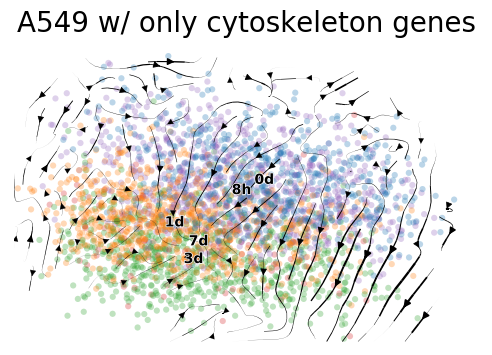

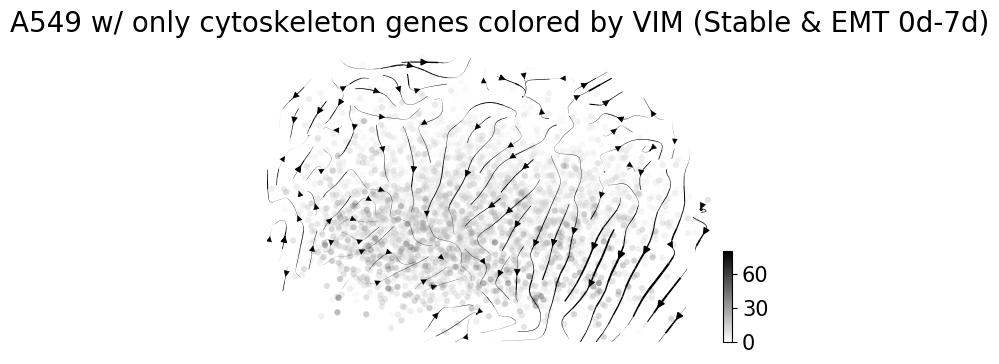

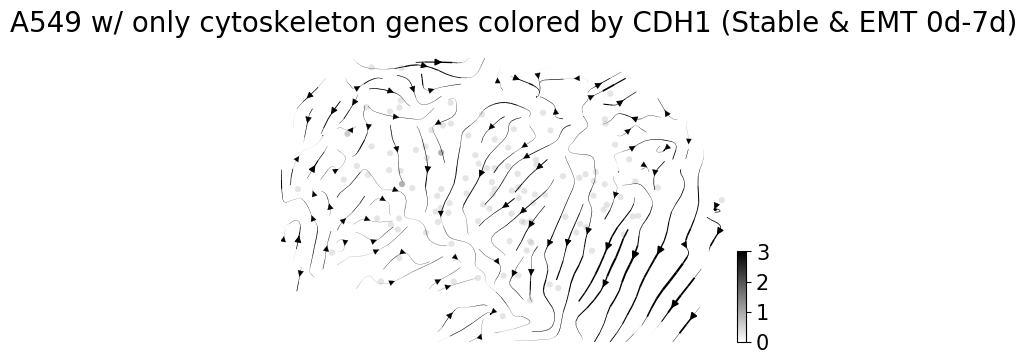

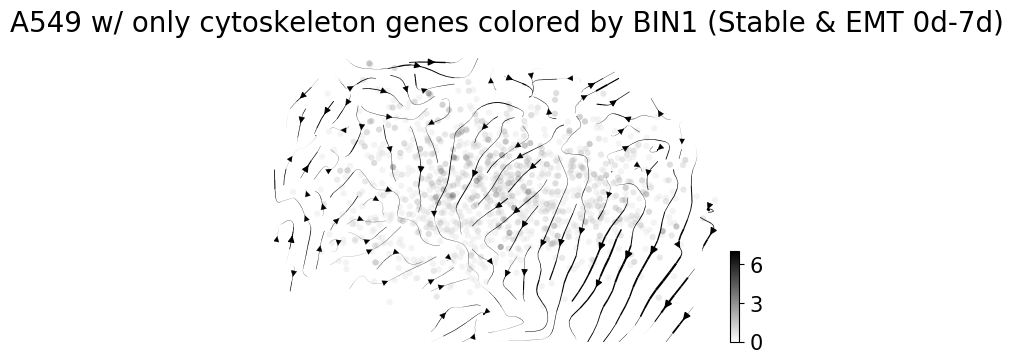

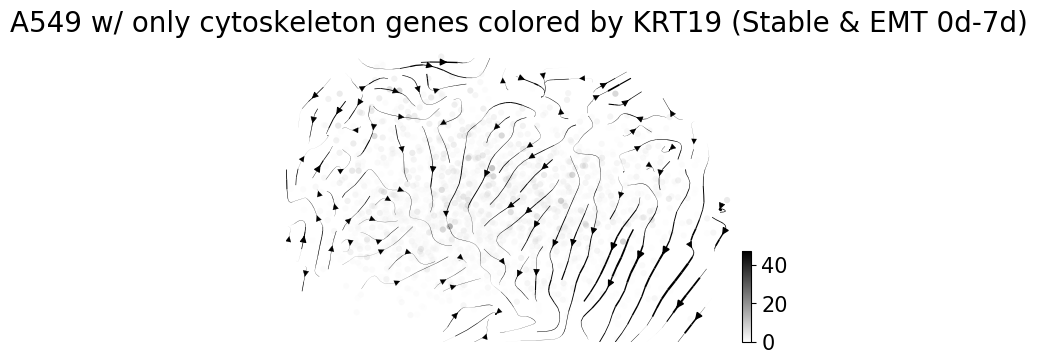

In [22]:
scv.pl.velocity_embedding_stream(stable_emt_adata, basis='pca',color='treatment',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes',
                                fontsize=20,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(stable_emt_adata, basis='pca',color='VIM',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes colored by VIM (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,cmap='binary',
                                 legend_fontsize=15,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(stable_emt_adata, basis='pca',color='CDH1',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes colored by CDH1 (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,cmap='binary',
                                 legend_fontsize=15,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(stable_emt_adata, basis='pca',color='BIN1',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes colored by BIN1 (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,legend_fontsize=15,smooth=1,cmap='binary',
                                 dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(stable_emt_adata, basis='pca',color='KRT19',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes colored by KRT19 (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,legend_fontsize=15,smooth=1,cmap='binary',
                                 dpi=100,size=80,density=0.5)
